# Bayesian Optimization with a Hessian
Here we demonstrate the use of a Hessian matrix to estimate the kernel.

## Specifiying generator options
We start with the generator defaults and add a hessian kernel to the model. This also
 requires specifying that we will not normalize inputs to the GP model. Note: this
 can potentially mess up training of other hyperparameters.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import torch
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.custom_botorch.hessian_kernel import HessianRBF
from gpytorch.kernels import ScaleKernel
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


vocs = deepcopy(tnk_vocs)
vocs.objectives = {"y2":"MINIMIZE"}

# define a custom kernel and create the model constructor
hessian_matrix = torch.tensor([[1, -0.8], [-0.8, 1]]).double()
kernel = ScaleKernel(HessianRBF(hessian_matrix))
gp_constructor = StandardModelConstructor(
    covar_modules={"y2": kernel}
)


generator = UpperConfidenceBoundGenerator(
    vocs=vocs, gp_constructor=gp_constructor
)
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_TNK)

X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 0+untagged.1.gf312347
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs

## Evaluate explict points and view model
We start with evaluating 2 points that we know satisfy the constraints. Note the
cross correlations between x1,x2 due to the Hessian kernel.

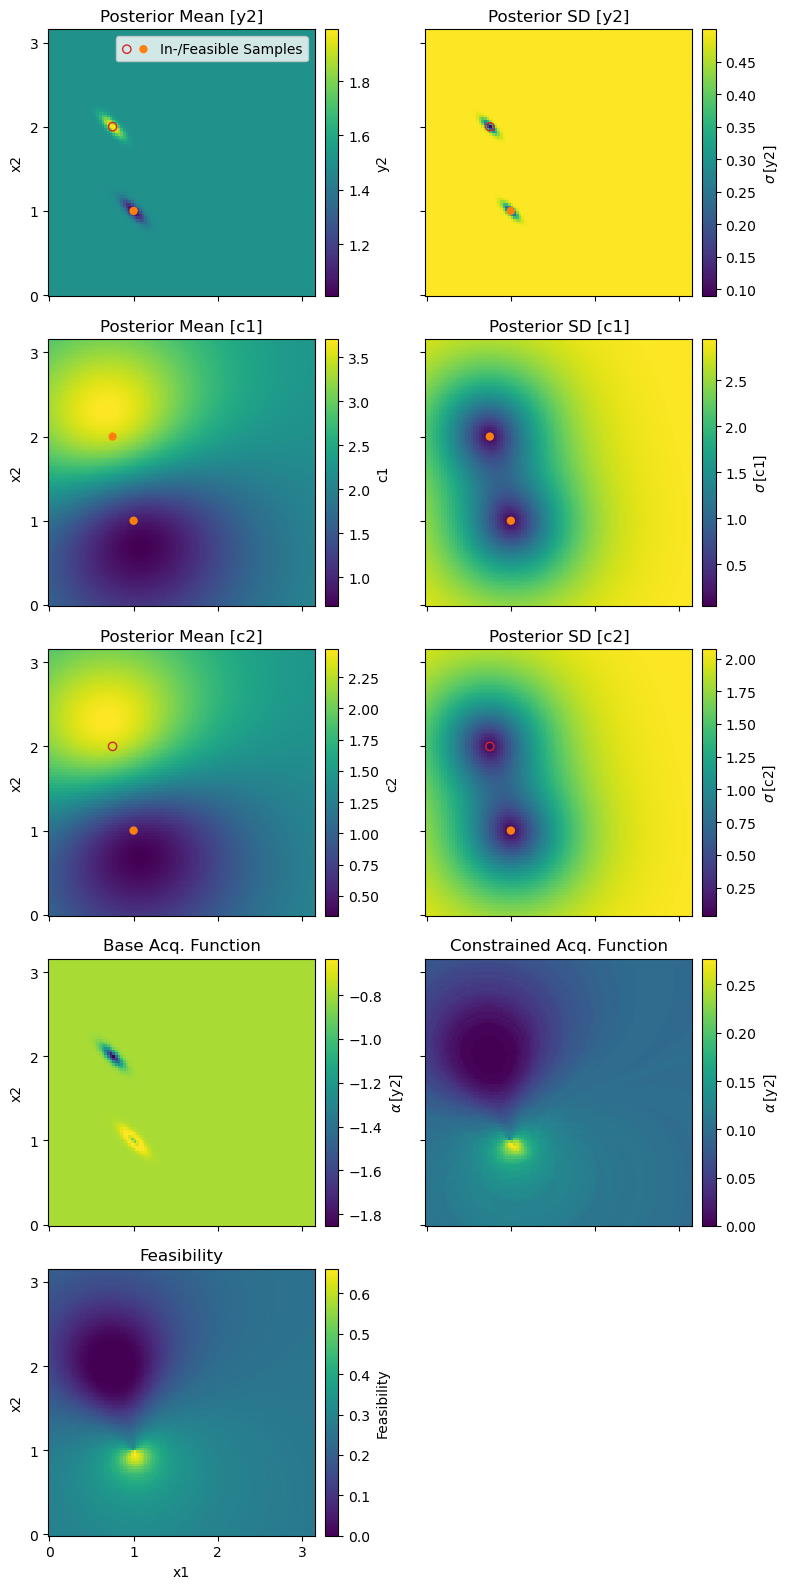

In [2]:
X.evaluate_data({"x1":[1.0, 0.75],"x2":[1.0, 2.0]})
X.generator.train_model()
fig, ax = X.generator.visualize_model(show_feasibility=True, n_grid=100)


In [3]:
X.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.00,1.0,dummy_constant,1.00,1.0,0.900000,0.5000,0.000037,False
1,0.75,2.0,dummy_constant,0.75,2.0,3.476876,2.3125,0.000008,False
